In [48]:
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from loader import *
import glob
import numpy as np
import copy
import yaml
from sklearn.metrics import f1_score
from tqdm import tqdm
from model.vision_transformer import SwinUnet as ViT_seg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.ndimage.morphology import binary_fill_holes, binary_opening
from sklearn.metrics import f1_score
import argparse
from configs import swin_attention_unet as config
from types import SimpleNamespace 

In [49]:
## Hyper parameters
config         = yaml.load(open('./config_skin.yml'), Loader=yaml.FullLoader)
number_classes = int(config['number_classes'])
input_channels = 3
best_val_loss  = np.inf
patience       = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_path = config['path_to_data']

test_dataset = isic_loader(path_Data = data_path, train = False, Test = True)
# test_loader  = DataLoader(test_dataset, batch_size = 1, shuffle= True)
test_loader  = DataLoader(test_dataset, batch_size = 1)


In [50]:
parser = argparse.ArgumentParser()
parser.add_argument('--root_path', type=str,
                    default='./Synapse/', help='root dir for data')
parser.add_argument('--eval_interval', type=int, default=5, help='eval interval')
parser.add_argument('--volume_path', type=str,
                    default='./Synapse/', help='root dir for validation volume data')
parser.add_argument('--dataset', type=str,
                    default='Synapse', help='experiment_name')
parser.add_argument('--list_dir', type=str,
                    default='./lists/lists_Synapse', help='list dir')
parser.add_argument('--num_classes', type=int,
                    default=9, help='output channel of network')
parser.add_argument('--saved_model', type=str,
                    default='./weights/weights_isic17.model' , help='output dir')                   
parser.add_argument('--max_iterations', type=int,
                    default=30000, help='maximum epoch number to train')
parser.add_argument('--max_epochs', type=int,
                    default=150, help='maximum epoch number to train')
parser.add_argument('--batch_size', type=int,
                    default=24, help='batch_size per gpu')
parser.add_argument('--n_gpu', type=int, default=1, help='total gpu')
parser.add_argument('--deterministic', type=int,  default=1,
                    help='whether use deterministic training')
parser.add_argument('--base_lr', type=float,  default=0.01,
                    help='segmentation network learning rate')
parser.add_argument('--img_size', type=int,
                    default=224, help='input patch size of network input')
parser.add_argument('--seed', type=int,
                    default=1234, help='random seed')
parser.add_argument('--cfg', type=str, default='configs/swin_tiny_patch4_window7_224_lite.yaml', metavar="FILE", help='path to config file', )
parser.add_argument(
        "--opts",
        help="Modify config options by adding 'KEY VALUE' pairs. ",
        default=None,
        nargs='+',
    )
parser.add_argument('--zip', action='store_true', help='use zipped dataset instead of folder dataset')
parser.add_argument('--cache-mode', type=str, default='part', choices=['no', 'full', 'part'],
                    help='no: no cache, '
                            'full: cache all data, '
                            'part: sharding the dataset into nonoverlapping pieces and only cache one piece')
parser.add_argument('--resume', help='resume from checkpoint')
parser.add_argument('--accumulation-steps', type=int, help="gradient accumulation steps")
parser.add_argument('--use-checkpoint', action='store_true',
                    help="whether to use gradient checkpointing to save memory")
parser.add_argument('--amp-opt-level', type=str, default='O1', choices=['O0', 'O1', 'O2'],
                    help='mixed precision opt level, if O0, no amp is used')
parser.add_argument('--tag', help='tag of experiment')
parser.add_argument('--eval', action='store_true', help='Perform evaluation only')
parser.add_argument('--throughput', action='store_true', help='Test throughput only')
parser.add_argument('--mode', help='Select our contribution',
                    choices=['swin','cross_contextual_attention', default='swin')
parser.add_argument('--skip_num', help='Select our contribution',
                    choices=['0', '1', '2','3'], default='3'),
parser.add_argument('--operationaddatten', help='Select our contribution',
                    choices=['+', 'mul'], default='+')
parser.add_argument('--attention', help='0 or 1',
                    choices=['0',"1"], default="0")
                
args = parser.parse_args(args=[])

args.mode = "swin"
args.attention = "1"
args.operationaddatten = "+"


if args.dataset == "Synapse":
    args.root_path = os.path.join(args.root_path, "train_npz")
                             
config =  config.get_swin_unet_attention_configs().to_dict()
config.update(vars(args))
configs = SimpleNamespace(**config)


=> merge config from configs/swin_tiny_patch4_window7_224_lite.yaml


In [51]:
Net = ViT_seg(config_model, img_size= 224, num_classes=number_classes)

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.2;num_classes:1
------------------------------ 1 <class 'str'>
mode: swin skip_num 3 cross_num 3


In [52]:
# config_model = get_config() 
# Net = ViT_seg(config_model, img_size= 224, num_classes=number_classes)
# Net.load_from(config_model)
# --mode swin --attention 1 --operationaddatten +
# --mode crossatten_v2 --cross_num 1 --attention 0

# model 1: weights_isic17_cross_without_attention_v1_cross_num_2.model | --mode crossatten_v1 --cross_num 2 --attention 0 |
# model 2: weights_isic17_dualattention_with_attention_mul_ch2_sp_2.model | --mode dualattention --attention 1 --operationaddatten mul  --num_channel 2  --num_spatial 2 | 0.8515
# model 3: weights_isic17_cross_without_attention_v2_cross_num_1.model | --mode crossatten_v2 --cross_num 1 --attention 0 |
# model 4: weights_isic17_swin_with_attention_add.model | --mode swin --attention 1 --operationaddatten + | 0.9246
Net = Net.to(device)
add = r"./weights/weights_isic17_swin_with_attention_add.model" 
Net.load_state_dict(torch.load(add, map_location='cpu')['model_weights'])


<All keys matched successfully>

## Quntitative performance

In [4]:
# predictions = []
# gt = []

# with torch.no_grad():
#     print('val_mode')
#     val_loss = 0
#     Net.eval()
#     for itter, batch in tqdm(enumerate(test_loader)):
#         img = batch['image'].to(device, dtype=torch.float)
#         msk = batch['mask']
#         msk_pred = Net(img)

#         gt.append(msk.numpy()[0, 0])
#         msk_pred = msk_pred.cpu().detach().numpy()[0, 0]
#         msk_pred  = np.where(msk_pred>=0.43, 1, 0)
#         msk_pred = binary_opening(msk_pred, structure=np.ones((6,6))).astype(msk_pred.dtype)
#         msk_pred = binary_fill_holes(msk_pred, structure=np.ones((6,6))).astype(msk_pred.dtype)
#         predictions.append(msk_pred)        
        
        
        
# predictions = np.array(predictions)
# gt = np.array(gt)

# y_scores = predictions.reshape(-1)
# y_true   = gt.reshape(-1)

# y_scores2 = np.where(y_scores>0.47, 1, 0)
# y_true2   = np.where(y_true>0.5, 1, 0)

# #F1 score
# F1_score = f1_score(y_true2, y_scores2, labels=None, average='binary', sample_weight=None)
# print ("\nF1 score (F-measure) or DSC: " +str(F1_score))
# confusion = confusion_matrix(np.int32(y_true), y_scores2)
# print (confusion)
# accuracy = 0
# if float(np.sum(confusion))!=0:
#     accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
# print ("Accuracy: " +str(accuracy))
# specificity = 0
# if float(confusion[0,0]+confusion[0,1])!=0:
#     specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
# print ("Specificity: " +str(specificity))
# sensitivity = 0
# if float(confusion[1,1]+confusion[1,0])!=0:
#     sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
# print ("Sensitivity: " +str(sensitivity))




val_mode


400it [00:10, 38.79it/s]



F1 score (F-measure) or DSC: 0.9214112163999334
[[15771484   392266]
 [  268108  3638542]]
Accuracy: 0.9670971181441327
Specificity: 0.9757317454179878
Sensitivity: 0.9313713795707319


## Visualization section

In [53]:
def save_sample(img, msk, msk_pred, th=0.3, name=''):
    img2 = img.detach().cpu().numpy()[0]
    img2 = np.einsum('kij->ijk', img2)
    msk2 = msk.detach().cpu().numpy()[0,0]
    mskp = msk_pred.detach().cpu().numpy()[0,0]
    msk2 = np.where(msk2>0.5, 1., 0)
    mskp = np.where(mskp>=th, 1., 0)

    plt.figure(figsize=(7,15))

    plt.subplot(3,1,1)
    plt.imshow(img2/255.)
    plt.axis('off')

    plt.subplot(3,1,2)
    plt.imshow(msk2*255, cmap= 'gray')
    plt.axis('off')

    plt.subplot(3,1,3)
    plt.imshow(mskp*255, cmap = 'gray')
    plt.axis('off')
    
    
    plt.savefig('./results/model4/'+name+'.png')


val_mode


20it [00:03,  6.64it/s]<ipython-input-53-aefee1888446>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,15))
400it [01:04,  6.19it/s]


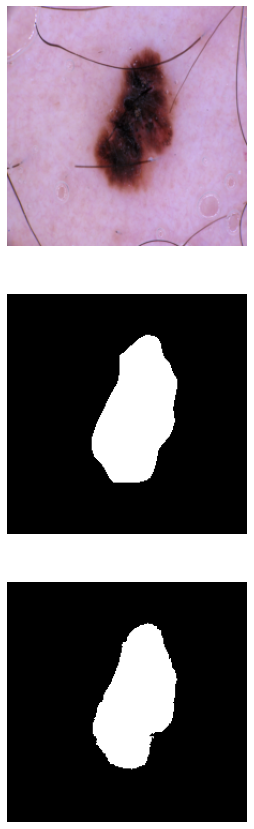

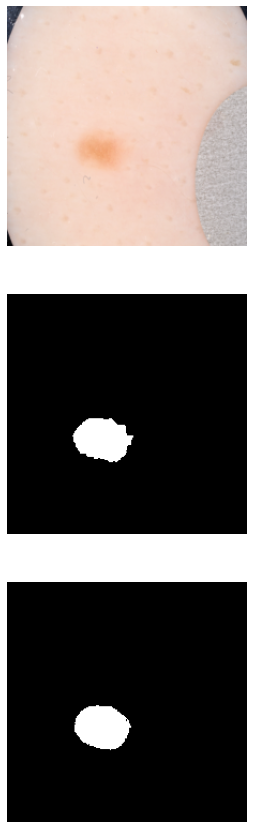

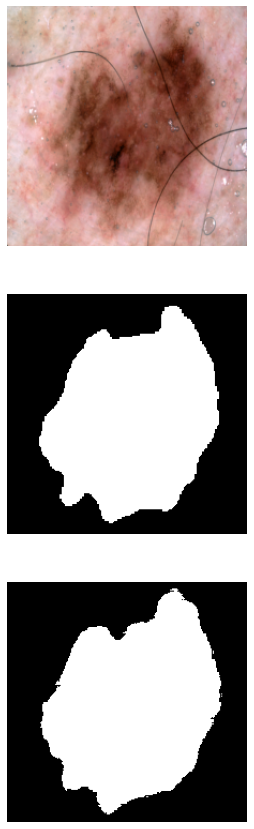

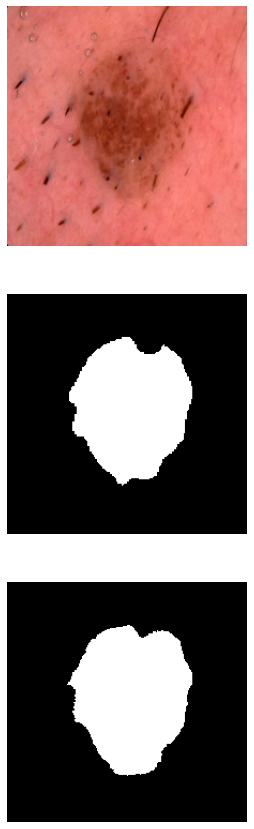

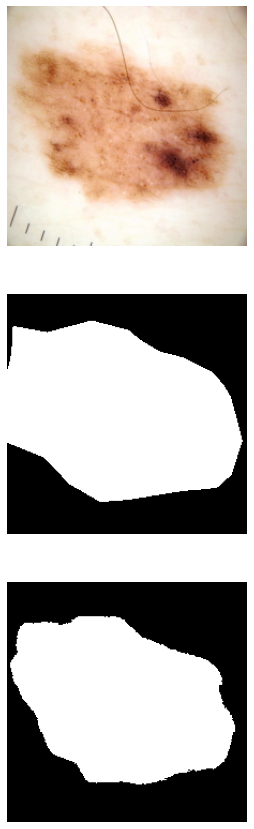

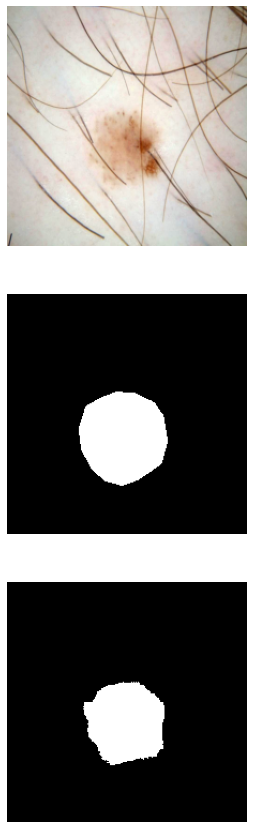

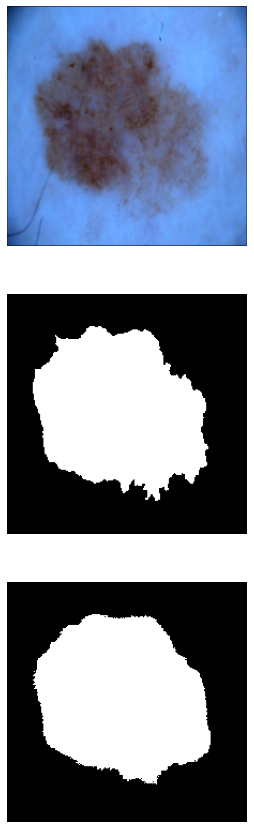

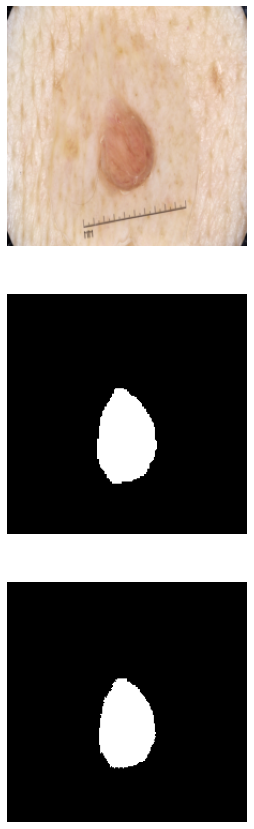

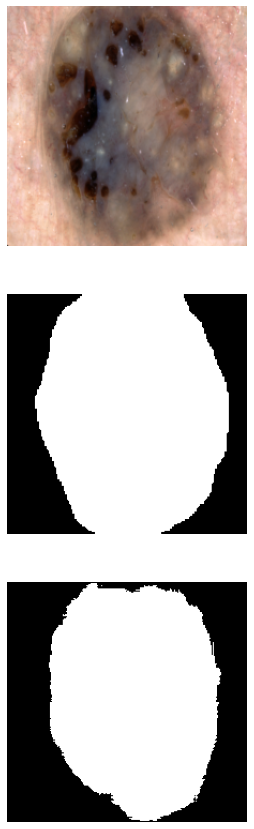

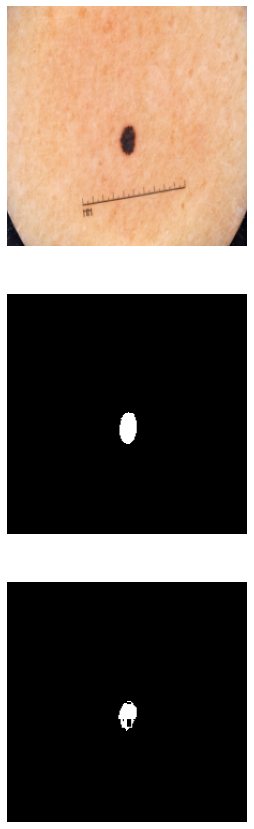

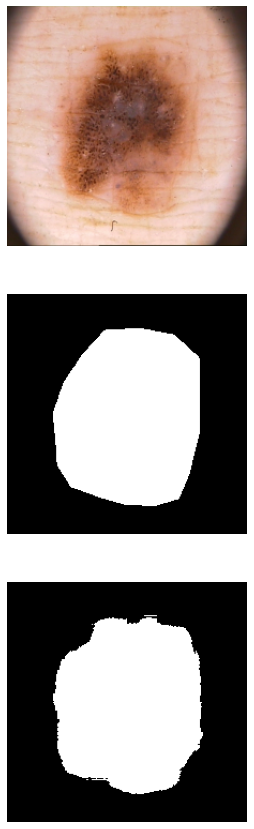

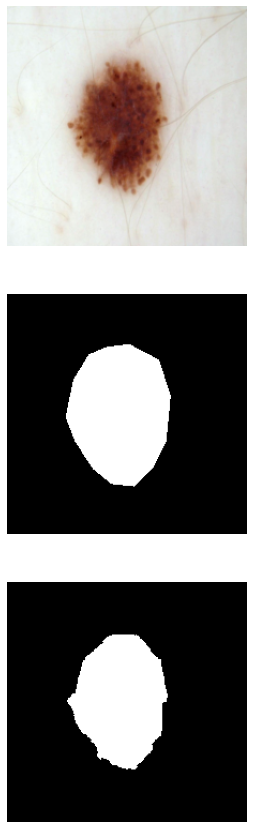

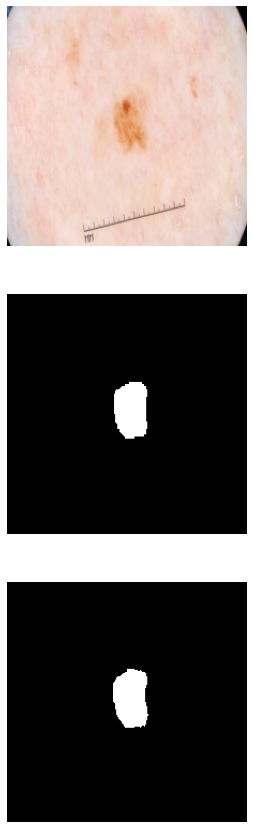

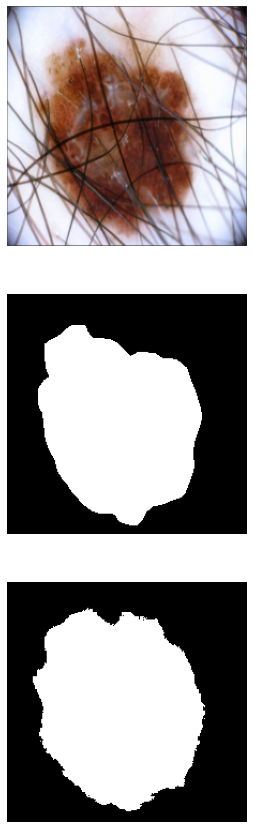

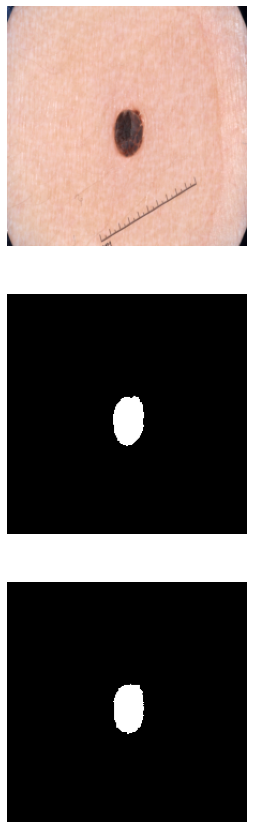

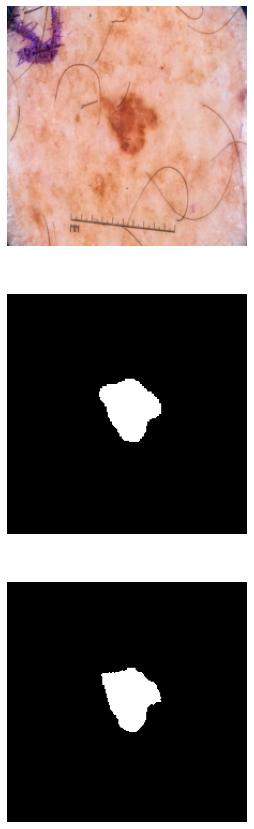

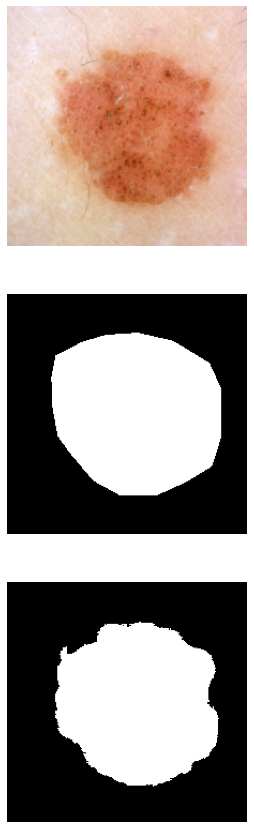

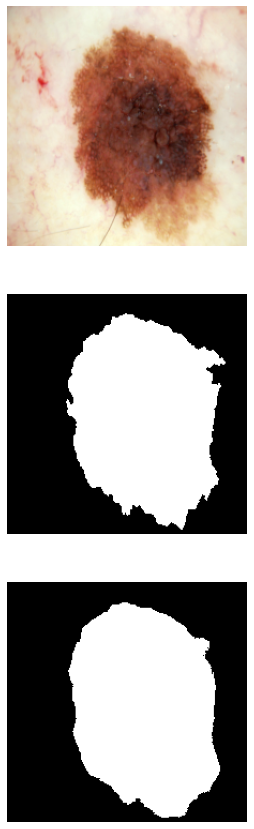

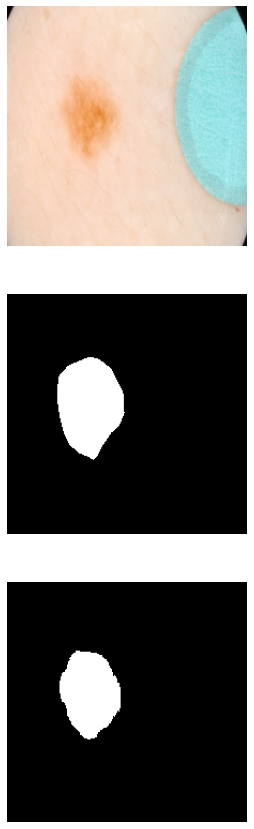

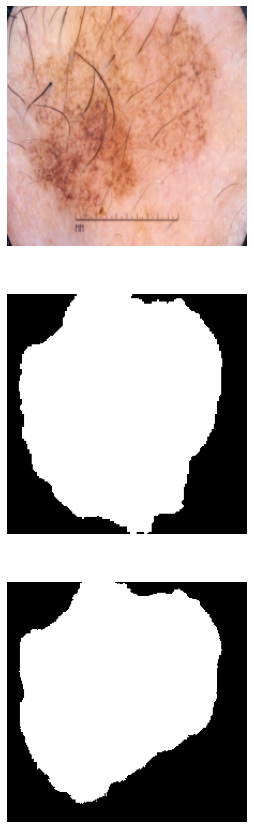

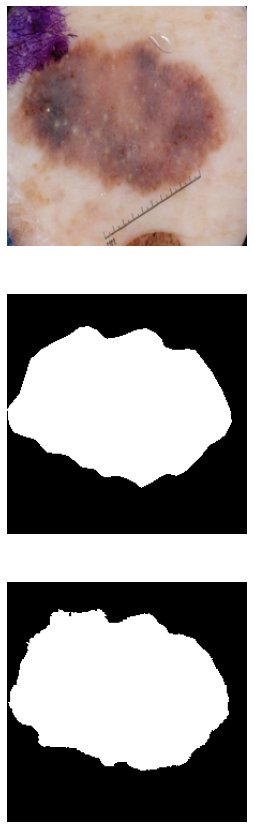

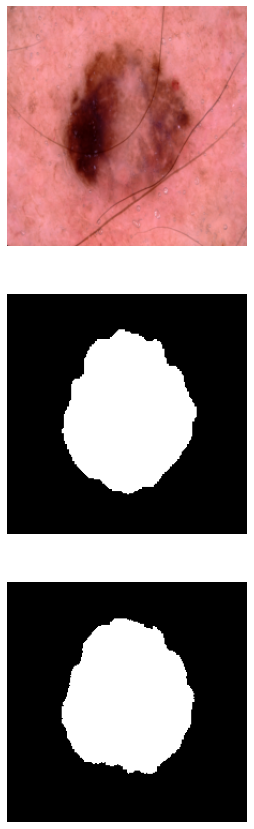

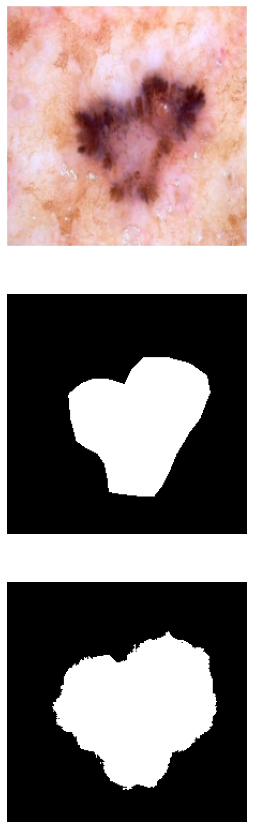

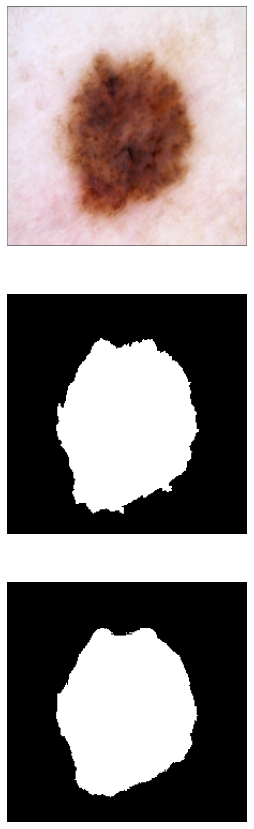

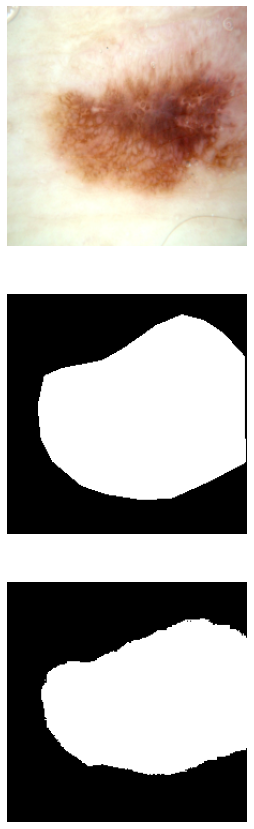

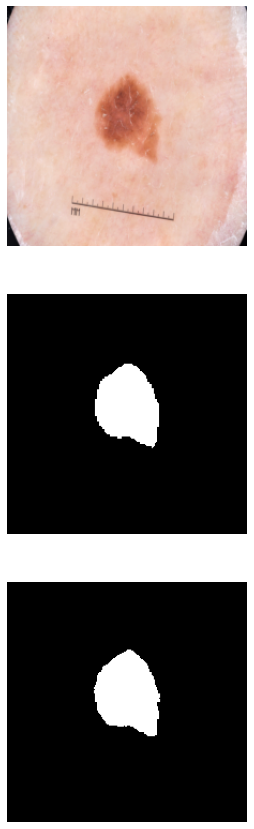

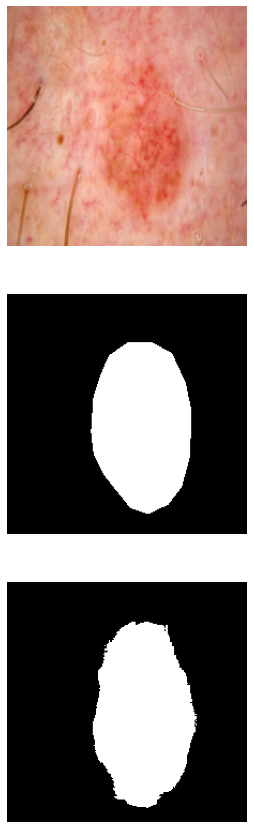

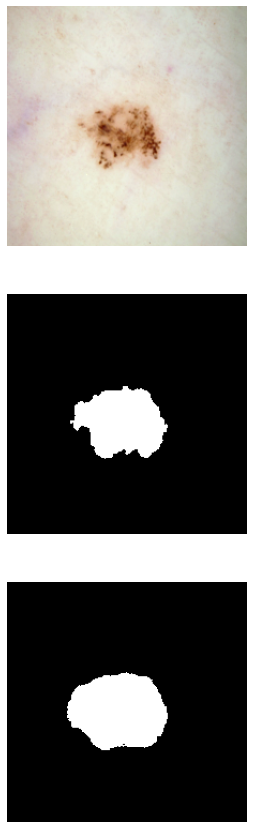

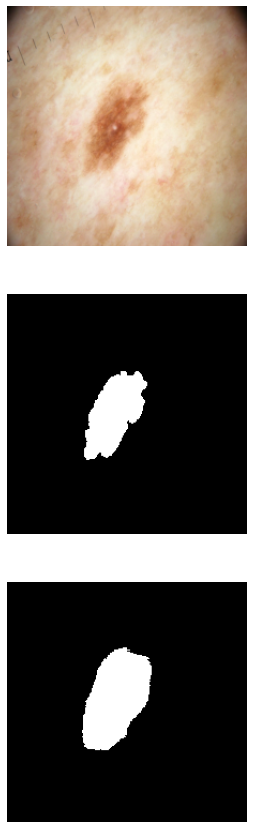

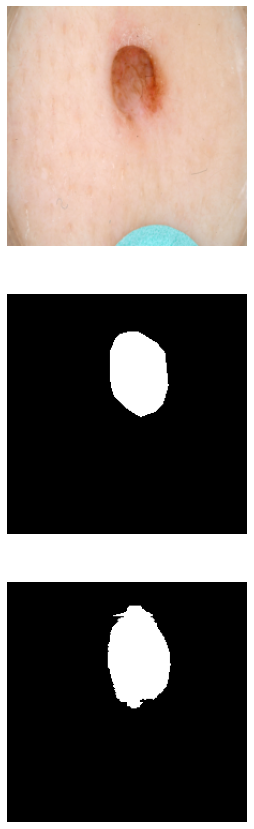

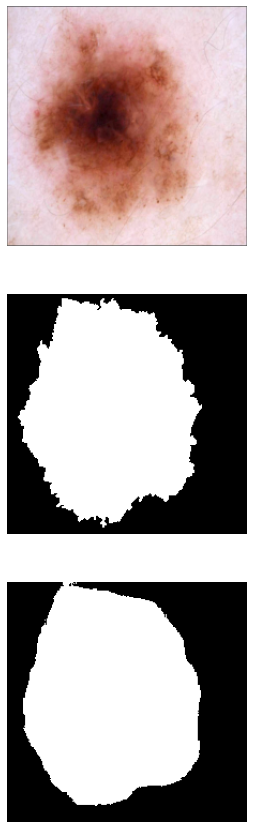

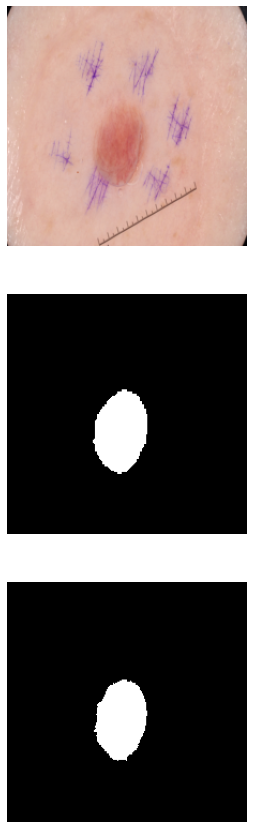

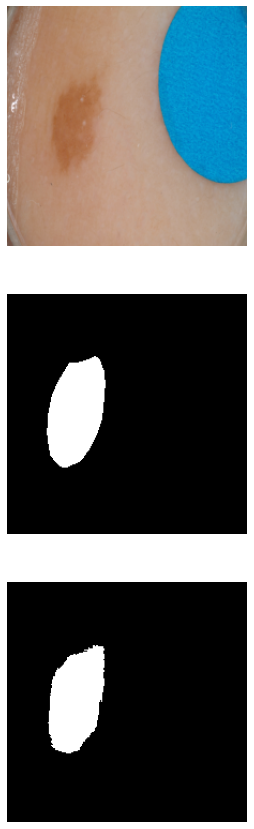

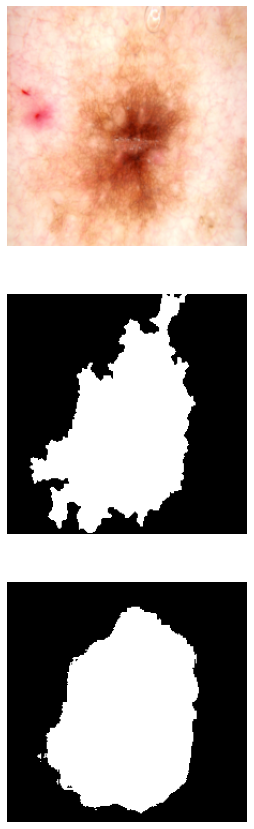

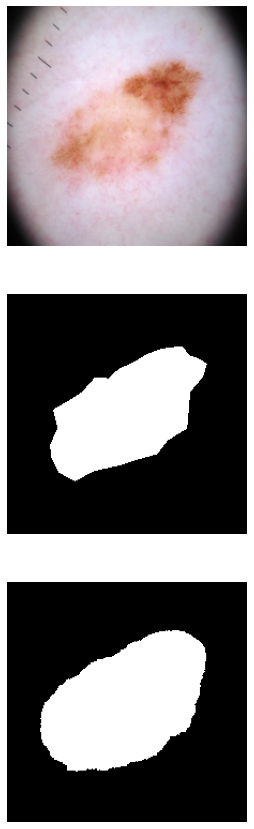

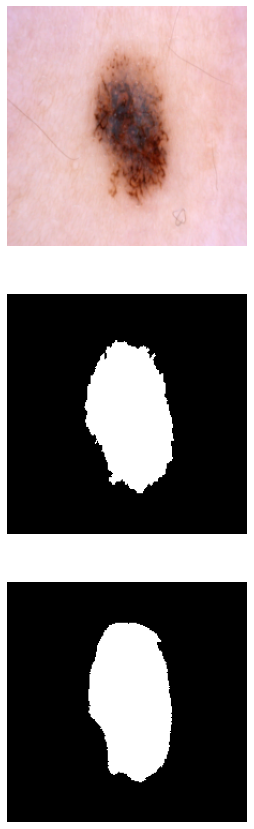

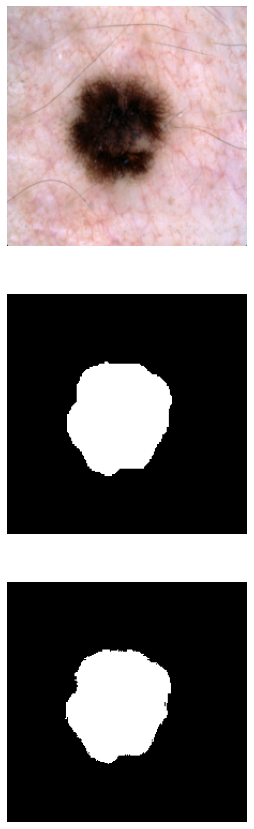

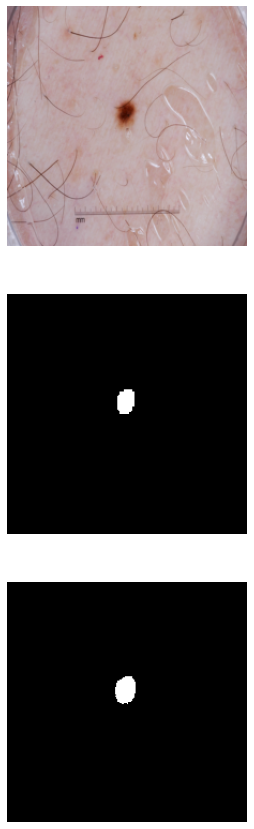

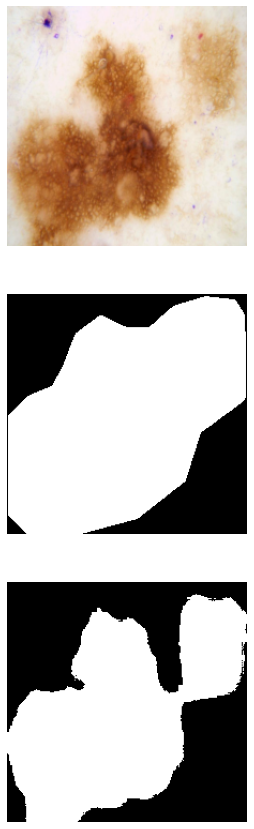

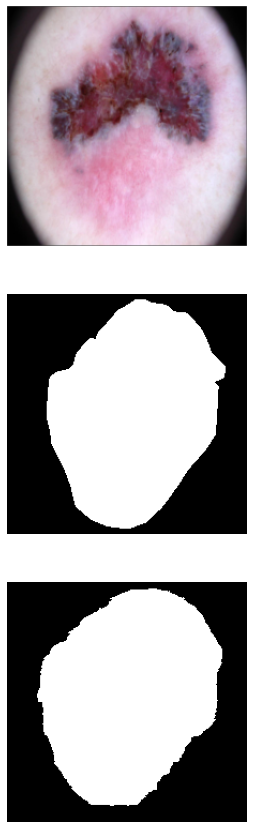

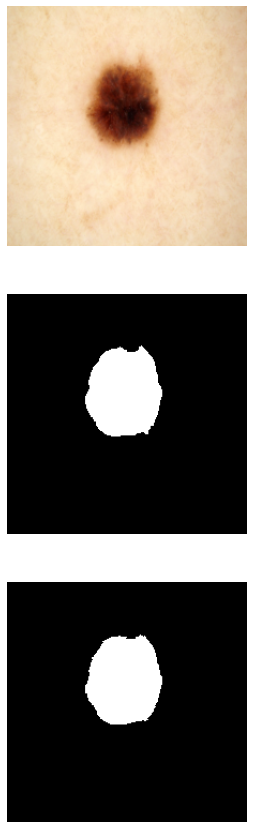

In [ ]:
predictions = []
gt = []

N = 5 ## Number of samples to visualize
with torch.no_grad():
    print('val_mode')
    val_loss = 0
    Net.eval()
    for itter, batch in tqdm(enumerate(test_loader)):
        img = batch['image'].to(device, dtype=torch.float)
        msk = batch['mask']
        msk_pred = Net(img)
        
        gt.append(msk.numpy())
        predictions.append(msk_pred.cpu().detach().numpy())
        save_sample(img, msk, msk_pred, th=0.5, name=str(itter+1))
#         if itter+1==N:
#             break
            